In [79]:
#Import libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [80]:
#time
# 2x : frame rate = 0,5 frames per second

def calculate_time_units(frames):
    """
    Calculate elapsed time in seconds, minutes, hours, and days for each frame.

    Args:
    frames (array-like): Continuous frame numbers.

    Returns:
    pandas.DataFrame: A DataFrame with columns for seconds, minutes, hours, and days.

    To run:
    time_columns = calculate_time_units(data['continuous_frames'])
    data = pd.concat([data, time_columns], axis=1)
    """
    frames = np.array(frames)  # Ensure input is a numpy array for vectorized computation

    # Calculate elapsed time in seconds
    elapsed_seconds = 2 * (frames)
    
    # Convert to other units
    elapsed_minutes = elapsed_seconds / 60
    elapsed_hours = elapsed_minutes / 60
    elapsed_days = elapsed_hours / 24

    # Return as a DataFrame
    return pd.DataFrame({
        'time_seconds': elapsed_seconds,
        'time_minutes': elapsed_minutes,
        'time_hours': elapsed_hours,
        'time_days': elapsed_days
    })



In [81]:
#speed variability
def calculate_speed_variability(data, interval, THEC):
    """
    Calculate speed variability over specified intervals.

    Args:
    data (pd.DataFrame): DataFrame containing at least the 'euclidean_speed' column.
    interval (int): Number of rows (frames) per interval.

    Returns:
    pd.DataFrame: DataFrame with new columns:
                  - 'std_speed': Standard deviation of speed in each interval
                  - 'mean_speed': Mean speed in each interval
                  - 'speed_variability': Ratio of std to mean in each interval
    """
    # Validate input
    if 'euclidean_speed' not in data.columns:
        raise ValueError("The DataFrame must contain a column named 'euclidean_speed'.")

    data['RoamingIndic'] = (data['euclidean_speed'] > THEC).astype(int)
    #data['Roaming_speed'] = data['Roaming2'][data['RoamingIndic'] == 1]
    
    # Calculate rolling statistics based on intervals
    rolling_std = data['euclidean_speed'].rolling(window=interval, min_periods=1).std()
    rolling_mean = data['euclidean_speed'].rolling(window=interval, min_periods=1).mean()
    #roaming_fraction = data['RoamingIndic'].sum() / len(data)

    # Assign computed values to new columns
    data['std_speed'] = rolling_std
    data['mean_speed'] = rolling_mean
    data['speed_variability'] = data['std_speed'] / data['mean_speed']
    data['roaming_frac'] = data['RoamingIndic'].rolling(window=interval, min_periods=1).mean()
    # Propagate interval values to all rows within the interval
    for col in ['std_speed', 'mean_speed', 'speed_variability']:
        data[col] = data[col].shift(-interval + 1).fillna(method='bfill')
        
    return data

def plot_data_over_interval(x, y, interval, x_label, y_label):
    """
    Plot speed variability over time.

    Args:
    data (pd.DataFrame): DataFrame containing 'speed_variability' and 'time'.
    interval (int): Interval used for calculations (used for graphing notes).
    """
    plt.figure(figsize=(10, 6))
    # Plot speed variability against time
    plt.plot(x, y, label=y_label, color='blue', linewidth=1.5)
    plt.title(f"{y_label} Over Time (Interval = {interval} frames)")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # plt.legend()
    plt.grid()
    plt.show()



In [82]:
threshold = 500
tolerance_speed = 0.1
speed_difference_threshold = 100
INTERVAL = 900
THEC = 3

def data_preprocess(file_csv):
    data = pd.read_csv(file_csv)

    data = data.dropna(subset=['X', 'Y']) # Drop rows with missing X or Y values
    data = data.reset_index(drop=True)

    data["continuous_frames"] = data.index + 1


    data['Instantaneous Distance'] = np.sqrt(
        (data['X'].diff() ** 2) + (data['Y'].diff() ** 2)
    ).fillna(0)
    data['Total Distance'] = data['Instantaneous Distance'].cumsum()
    data['Angle'] = np.arctan2(data['Y'].diff(), data['X'].diff()).fillna(0)    
    data['Angular Change'] = data['Angle'].diff().abs().fillna(0)


    data['euclidean_speed'] = np.sqrt((data['X'].diff())**2 + (data['Y'].diff())**2) * 2
    data['euclidean_speed'] = data['euclidean_speed'].shift(-1)

    
    data['speed_diff'] = data['euclidean_speed'] - data['Speed']
    data['speed_diff'] = np.where(abs(data['speed_diff']) < 0.01, 0, data['speed_diff'])

    time_columns = calculate_time_units(data['continuous_frames'])
    data = pd.concat([data, time_columns], axis=1)
    data = calculate_speed_variability(data, interval=INTERVAL, THEC=THEC)
    
    return data




C:\Users\srush\AppData\Local\Temp\ipykernel_12172\1519134371.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col] = data[col].shift(-interval + 1).fillna(method='bfill')


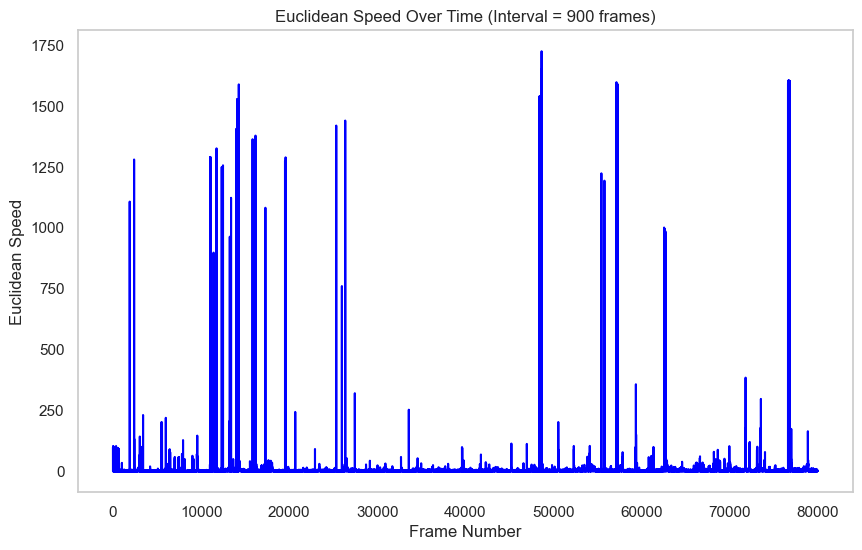

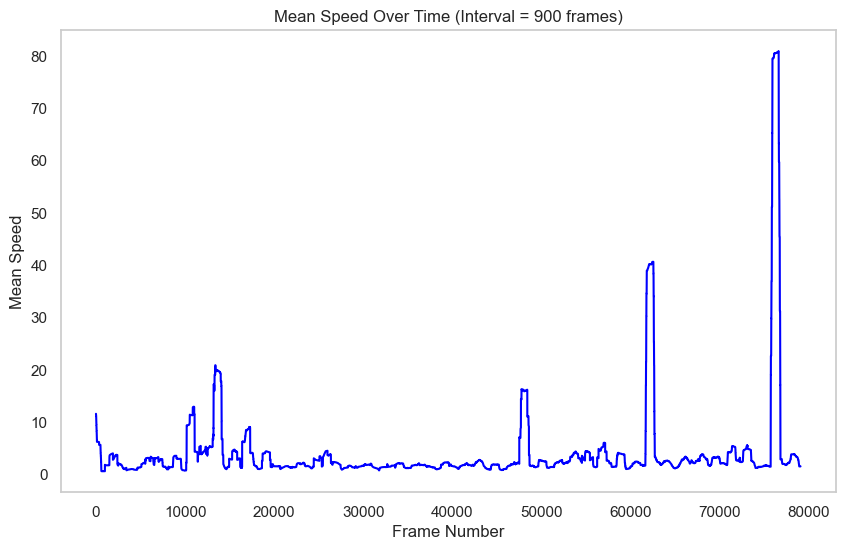

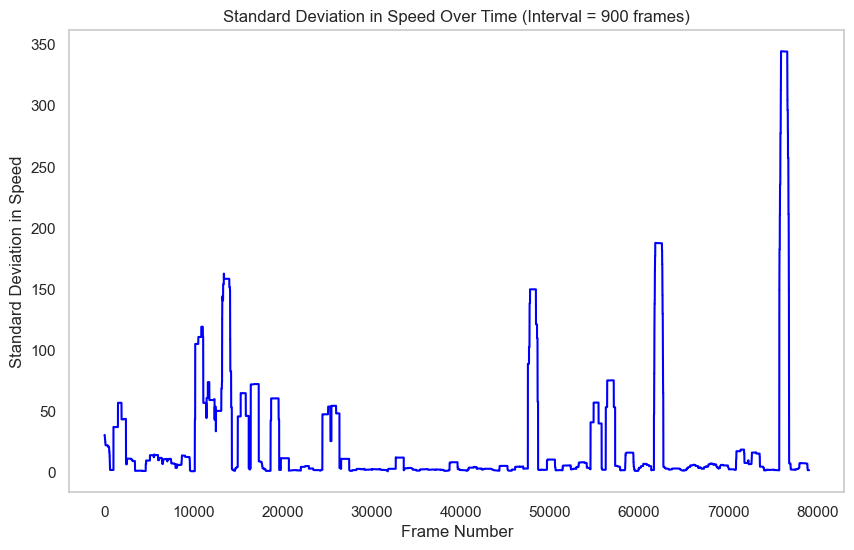

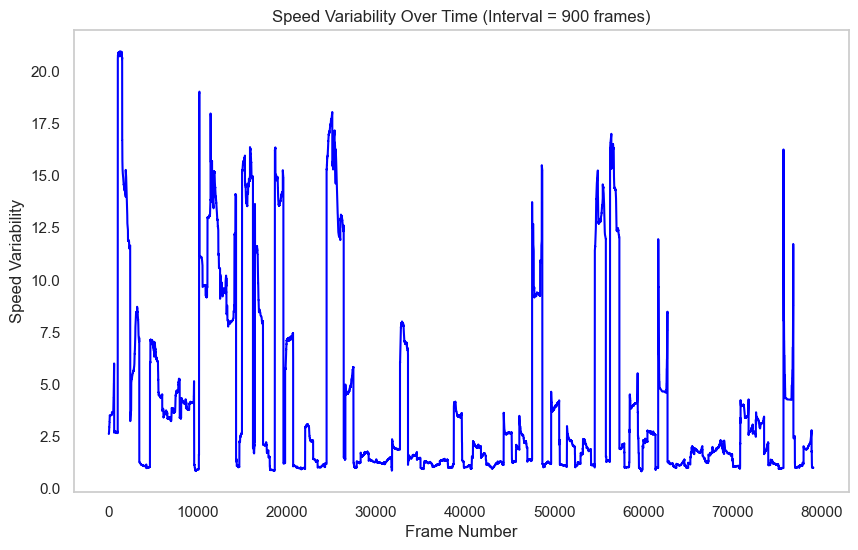

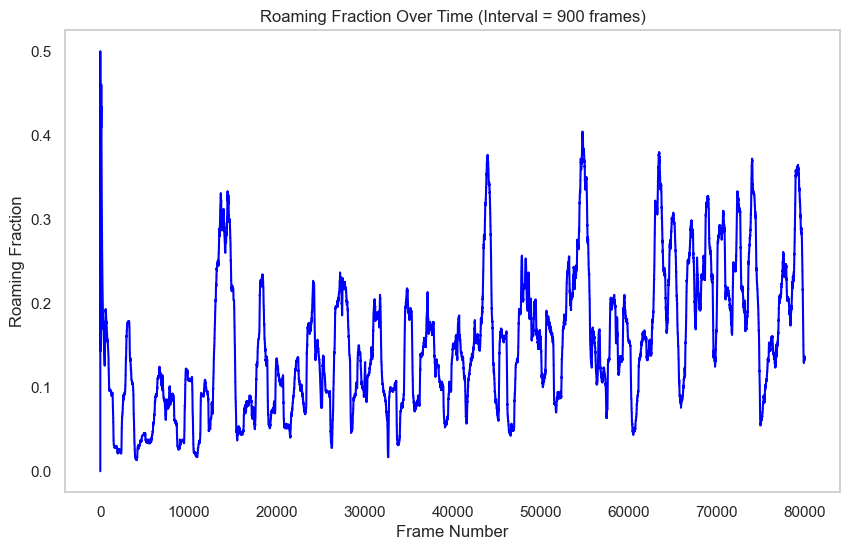

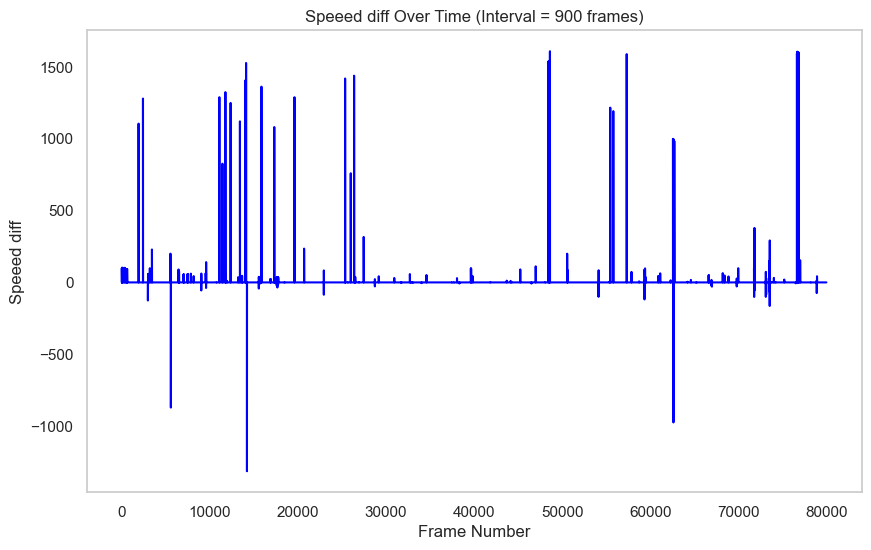

In [83]:
data = data_preprocess('Optogenetics-20241202T112946Z-001/Optogenetics/ATR+/speeds_and_coordinates_02piworm13_2_updated.csv')
data.head()
INTERVAL = 900

plot_data_over_interval(data.index, data['euclidean_speed'], x_label = "Frame Number", y_label="Euclidean Speed", interval=INTERVAL)
#plot_data_over_interval(data_updated.index, data_updated['Light_Pulse'], x_label = "Frame Number", y_label="Light Pulse", interval=INTERVAL)
plot_data_over_interval(data.index, data['mean_speed'], x_label = "Frame Number", y_label="Mean Speed", interval=INTERVAL)
plot_data_over_interval(data.index, data['std_speed'], x_label = "Frame Number", y_label="Standard Deviation in Speed", interval=INTERVAL)
plot_data_over_interval(data.index, data['speed_variability'], x_label = "Frame Number", y_label="Speed Variability", interval=INTERVAL)
plot_data_over_interval(data.index, data['roaming_frac'], x_label = "Frame Number", y_label="Roaming Fraction", interval=INTERVAL)
plot_data_over_interval(data.index, data['speed_diff'], x_label = "Frame Number", y_label="Speeed diff", interval=INTERVAL)



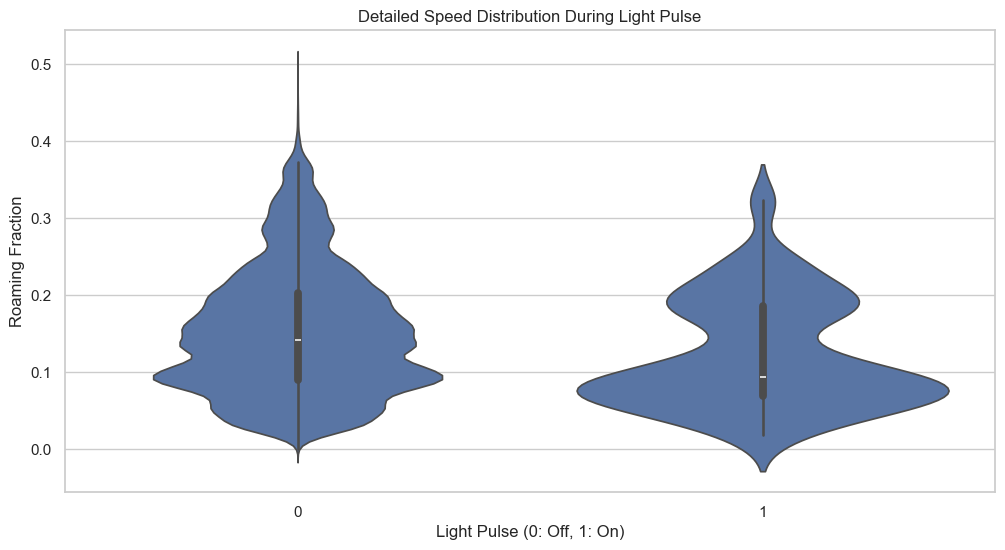

In [84]:
import seaborn as sns

def plotViolinBoxPLot(data):
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='Light_Pulse', y='roaming_frac', data=data)
    plt.title('Detailed Speed Distribution During Light Pulse')
    plt.xlabel('Light Pulse (0: Off, 1: On)')
    plt.ylabel('Roaming Fraction')
    plt.show()
    
'''
plt.figure(figsize=(12, 6))
sns.violinplot(x='Light_Pulse', y='roaming_frac', data=data)
plt.title('Detailed Speed Distribution During Light Pulse')
plt.xlabel('Light Pulse (0: Off, 1: On)')
plt.ylabel('Roaming Fraction')
plt.show()'''

plotViolinBoxPLot(data)

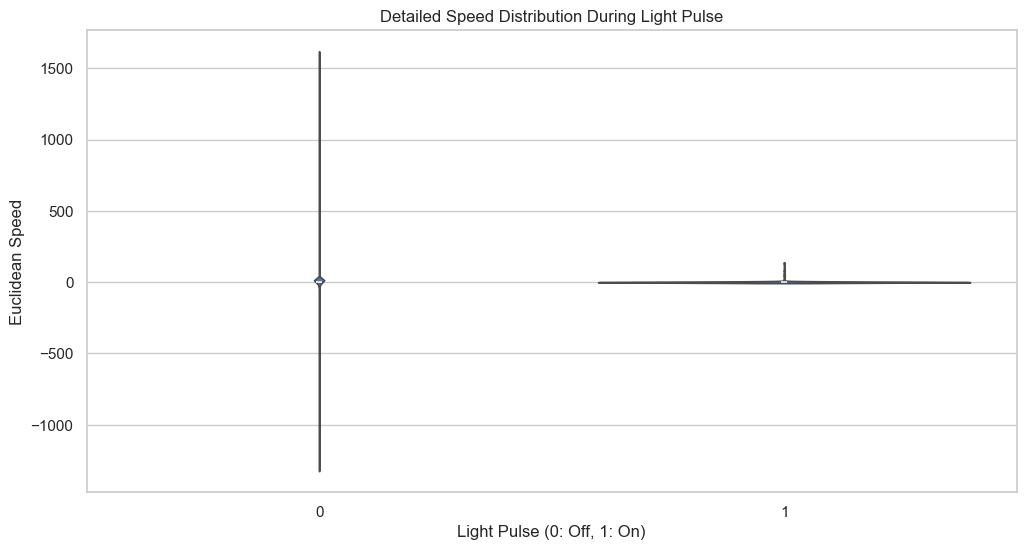

In [85]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.violinplot(x='Light_Pulse', y='speed_diff', data=data)
plt.title('Detailed Speed Distribution During Light Pulse')
plt.xlabel('Light Pulse (0: Off, 1: On)')
plt.ylabel('Euclidean Speed')
plt.show()

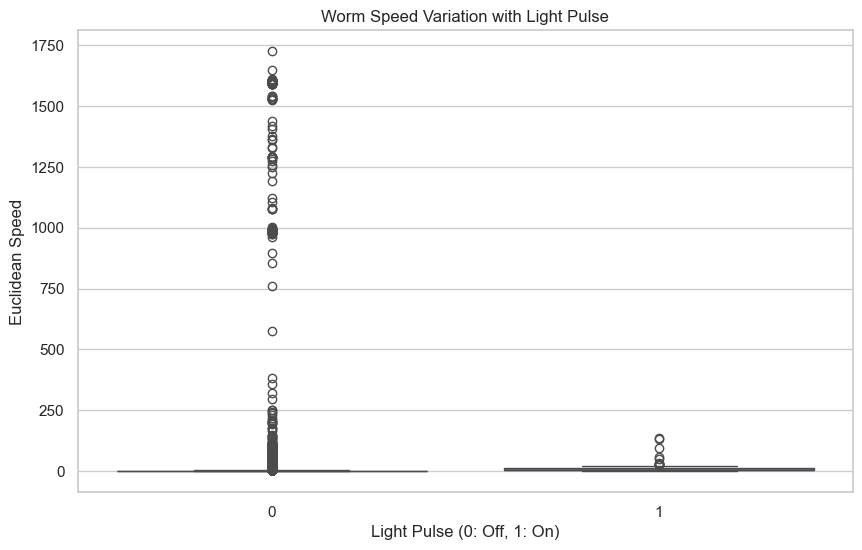

In [86]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Light_Pulse', y='euclidean_speed', data=data)
plt.title('Worm Speed Variation with Light Pulse')
plt.xlabel('Light Pulse (0: Off, 1: On)')
plt.ylabel('Euclidean Speed')
plt.show()

In [87]:
# CLustering
# 1) Drop irrelevant columns
# 2) Standardize/normalize the data


from sklearn.cluster import KMeans

columns_to_standardize = ['X', 'Y', 'euclidean_speed', 'roaming_frac', 'std_speed', 'mean_speed', 'speed_variability', 'speed_diff', 'Angular Change', 'Total Distance', 'Instantaneous Distance']
data[columns_to_standardize] = (data[columns_to_standardize] - data[columns_to_standardize].mean()) / data[columns_to_standardize].std()

features_cluster = ['X', 'Y', 'euclidean_speed', 'roaming_frac', 'Angular Change']
cluster_data = data[features_cluster]
cluster_data = cluster_data.fillna(0)



features = ['X', 'Y', 'euclidean_speed', 'roaming_frac', 'std_speed', 'mean_speed', 'speed_variability', 'speed_diff', 'Angular Change', 'Total Distance', 'Instantaneous Distance',
            'time_seconds', 'RoamingIndic', 'Angular Change']
new_data = data[features]
new_data = data.fillna(0)

print(new_data.iloc[:, 0:13])
print(type(new_data))  # Should be numpy.ndarray or pandas.DataFrame
print(new_data.shape)  # Should be (n_samples, n_features)
print(new_data.dtypes)


covMatrix = np.cov(new_data, rowvar=False)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(covMatrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
print ("values")
print (eigenvalues)
print ("vectors")
print (eigenvectors)
print(eigenvectors.shape)

explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
print(explained_variance_ratio)

k = 6  # Change this based on your needs
top_eigenvectors = eigenvectors[:, :k]


# Transform the data to the new PCA space
pca_transformed_data = np.dot(new_data, top_eigenvectors)



kmeans = KMeans(n_clusters=3)  # Experiment with cluster numbers
kmeans.fit(pca_transformed_data)
labels = kmeans.labels_
print(labels)
#new_data['Behavior_Cluster'] = kmeans.fit_predict(X_scaled)

#cluster_summary = new_data.groupby('Behavior_Cluster')[features].mean()
#print(cluster_summary)



       Frame     Speed         X         Y  Changed Pixels  Light_Pulse  \
0          1  0.180192 -0.104838 -0.085587               2            0   
1          2  0.671926 -0.105116 -0.085024               8            0   
2          3  0.133671  0.300947 -0.272677               3            0   
3          4  0.142243  0.301599 -0.272779              22            0   
4          5  3.081254  0.300985 -0.273017              41            0   
...      ...       ...       ...       ...             ...          ...   
79977  10795  0.554954 -0.591380  0.888212              10            0   
79978  10796  0.814406 -0.588928  0.887346              12            0   
79979  10797  0.509209 -0.585987  0.885486               7            0   
79980  10798  1.257194 -0.584025  0.884414              19            0   
79981  10799  0.376977 -0.580293  0.881083              37            0   

       continuous_frames  Instantaneous Distance  Total Distance     Angle  \
0                    

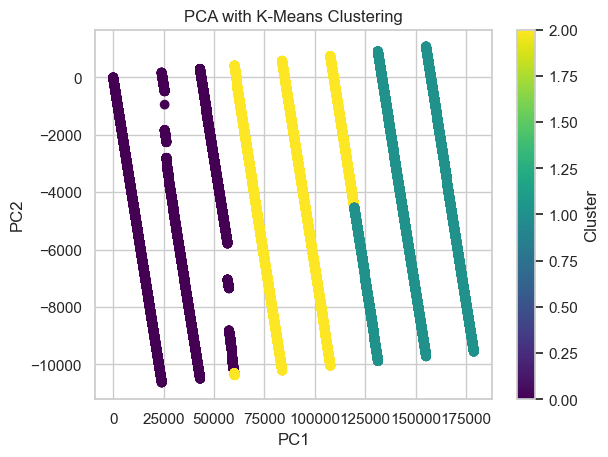

In [88]:
import matplotlib.pyplot as plt

# Plot the data points in the PCA-transformed space
plt.scatter(pca_transformed_data[:, 0], pca_transformed_data[:, 1], c=labels, cmap='viridis')

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with K-Means Clustering')
plt.colorbar(label='Cluster')
plt.show()




[2 0 0 ... 2 2 2]


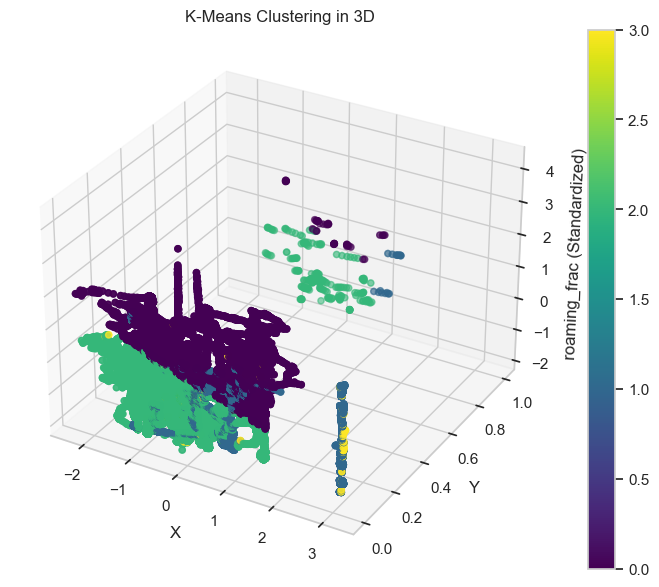

Cluster Centers (in standardized space):
[[ 4.73214434e-01  1.86519273e-01  2.52598854e-03 -2.62978736e-02
   1.26813210e+00]
 [ 1.14412757e+00 -2.14202242e+00  1.85507246e-03 -4.91112479e-02
  -3.07136178e-01]
 [-3.90967177e-01  2.93293034e-01  4.28472702e-03 -4.17417036e-02
  -4.63107567e-01]
 [ 1.51460334e+00 -1.73466750e+00 -8.67361738e-19  2.44361993e+01
  -2.09146169e-02]]
Silhouette Score: 0.3498868466856648


In [89]:
features_cluster = ['X', 'Y', 'Light_Pulse', 'euclidean_speed', 'roaming_frac']
cluster_data = data[features_cluster]
cluster_data = cluster_data.fillna(0)

kmeans = KMeans(n_clusters=4) 
kmeans.fit(cluster_data)
labels = kmeans.labels_
#data['Cluster'] = labels

print(labels)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = cluster_data.values[:, 0]  # X
y = cluster_data.values[:, 2]  # Light Pulse
z = cluster_data.values[:, 4]  # Roaming Fraction

# Scatter plot with color based on cluster labels
ax.scatter(x, y, z, c=labels, cmap='viridis', marker='o')

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('roaming_frac (Standardized)')
ax.set_title('K-Means Clustering in 3D')

# Show colorbar to show which color corresponds to which cluster
plt.colorbar(ax.scatter(x, y, z, c=labels, cmap='viridis', marker='o'))

plt.show()

'''
plt.scatter(cluster_data.values[:, 2], cluster_data.values[:, 3], c=labels, cmap='viridis')
plt.xlabel('Speed (Standardized)')
plt.ylabel('Instantaneous Distance (Standardized)')
plt.title('K-Means Clustering on Standardized Data')
plt.colorbar(label='Cluster')
plt.show()
'''
# check the cluster centers
print("Cluster Centers (in standardized space):")
print(kmeans.cluster_centers_)

# evaluate the clustering with silhouette score
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(cluster_data, labels)
print(f'Silhouette Score: {silhouette_avg}')

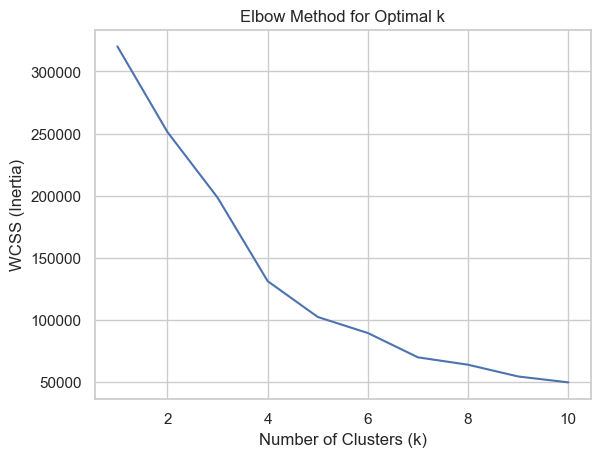

In [90]:
k_range = range(1, 11)

wcss = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_data)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.plot(k_range, wcss)
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.show()

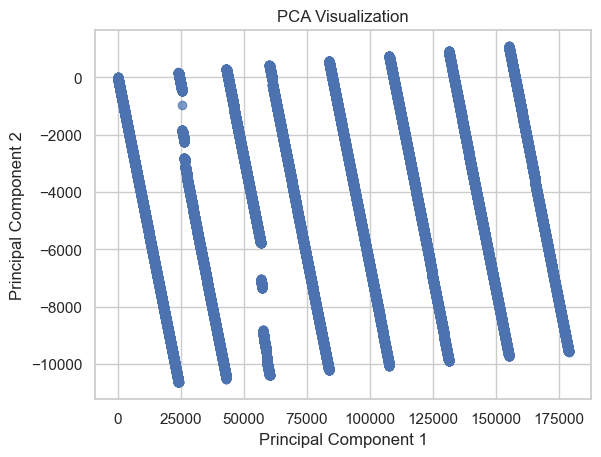

In [91]:

import matplotlib.pyplot as plt

# For 2D PCA
plt.scatter(pca_transformed_data[:, 0], pca_transformed_data[:, 1], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.show()


C:\Users\srush\AppData\Local\Temp\ipykernel_12172\2948715835.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


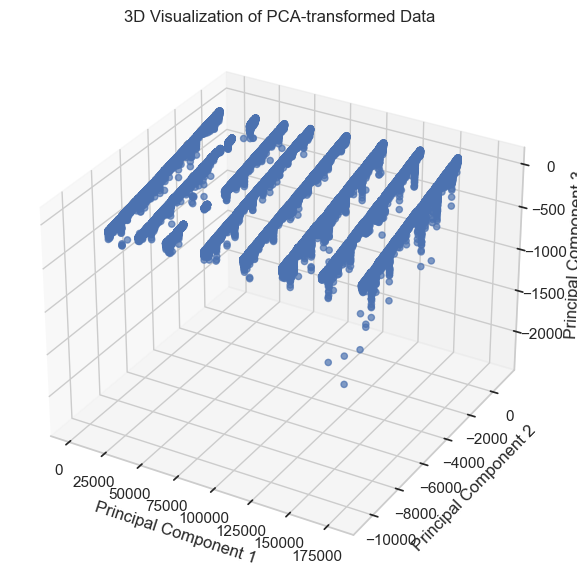

In [92]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with the first three principal components
ax.scatter(
    pca_transformed_data[:, 0],  # First principal component
    pca_transformed_data[:, 1],  # Second principal component
    pca_transformed_data[:, 2],  # Third principal componen
    cmap='viridis',             
    alpha=0.7  
)

# Label axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Set a title
ax.set_title('3D Visualization of PCA-transformed Data')

plt.show()


In [100]:

# Load the combined dataset
combined_data = pd.read_csv("merged_worm_data.csv")  # Replace with your combined dataset file

columns_to_standardize = ['X', 'Y', 'euclidean_speed', 'roaming_frac', 'std_speed', 'mean_speed', 'speed_variability', 'speed_diff', 'Angular Change', 'Total Distance', 'Instantaneous Distance', 'Changed Pixels', 'Angle']
combined_data[columns_to_standardize] = (combined_data[columns_to_standardize] - combined_data[columns_to_standardize].mean()) / combined_data[columns_to_standardize].std()

features = ['Frame','X', 'Y', 'Light_Pulse', 'euclidean_speed', 'roaming_frac', 'Angular Change', 'Instantaneous Distance', 'worm_id', 'time_hours', 'Changed Pixels', 'Total Distance', 'Angle', 'speed_diff', 'std_speed', 'mean_speed', 'speed_variability']
combined_data = combined_data[features]

combined_data = combined_data.sort_values(by=['worm_id', 'Frame'])
#print(combined_data['euclidean_speed'].isna().sum())  # Outputs the number of NaN values in the 'speed' column
#print(combined_data['Instantaneous Distance'].isna().sum())
combined_data = combined_data.fillna(0)

train_data = combined_data.groupby('worm_id').apply(lambda x: x.iloc[:len(x)//2]).reset_index(drop=True)
test_data = combined_data.groupby('worm_id').apply(lambda x: x.iloc[len(x)//2:]).reset_index(drop=True)

# Separate features and target for training
X_train = train_data.drop(columns=['euclidean_speed', 'Frame'])

y_train = train_data['euclidean_speed']

# Prepare test features (exclude speed for testing)
X_test = test_data.drop(columns=['euclidean_speed', 'Frame'])
y_test = test_data['euclidean_speed']
mean_speed = y_test.mean()
print(mean_speed)


C:\Users\srush\AppData\Local\Temp\ipykernel_12172\807588591.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = combined_data.groupby('worm_id').apply(lambda x: x.iloc[:len(x)//2]).reset_index(drop=True)
C:\Users\srush\AppData\Local\Temp\ipykernel_12172\807588591.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_data = combined_data.groupby('worm_id').apply(lambda x: x.iloc[len(x)//2:]

-0.002135828018637299


Linear regression 

Linear Regression Performance:
Mean Squared Error (MSE): 0.33278853449238804
Mean Absolute Error (MAE): 0.10117779076579417
R² Score: 0.6915436586982893
Root Mean Squared Error (RMSE): 0.5768782666147062


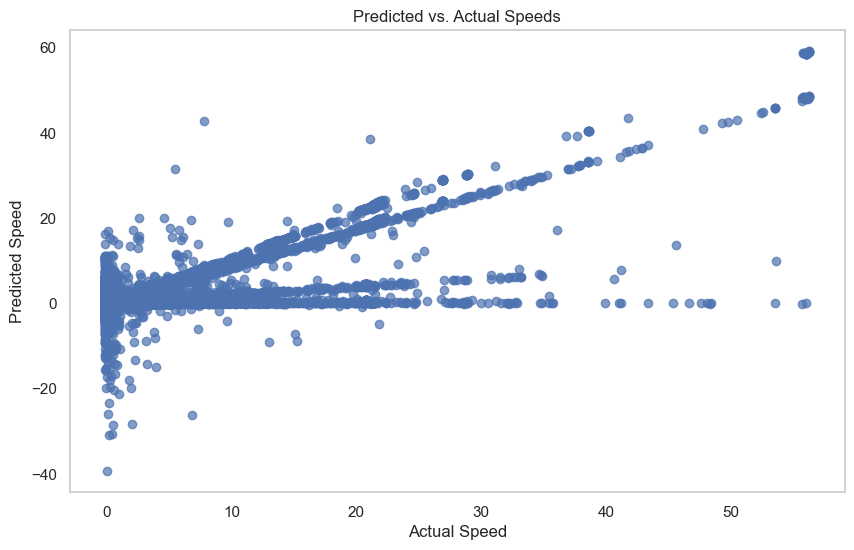

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Print evaluation metrics
print("Linear Regression Performance:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the predicted vs. actual speeds
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.title("Predicted vs. Actual Speeds")
plt.xlabel("Actual Speed")
plt.ylabel("Predicted Speed")
plt.grid()
plt.show()



In [102]:
print(y_test.shape)

(1154426,)


In [103]:
y_pred_series = pd.Series(y_pred, index=y_test.index, name='predicted_speed')

# Step 2: Combine everything into a single DataFrame
df = pd.DataFrame({
    'actual_speed': y_test,
    'predicted_speed': y_pred_series,
    'worm_id': test_data['worm_id'],  
})

# Step 3: Plot actual vs predicted speed for each worm
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='actual_speed', y='predicted_speed', hue='worm_id', palette='Set2', alpha=0.6)
plt.plot([df['actual_speed'].min(), df['actual_speed'].max()],
         [df['actual_speed'].min(), df['actual_speed'].max()],
         linestyle='--', color='red', label='Ideal (Actual = Predicted)')
plt.title('Actual vs Predicted Speed (All Worms)')
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.legend(title='Worm ID')
plt.show()




c:\Users\srush\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


KeyboardInterrupt: 

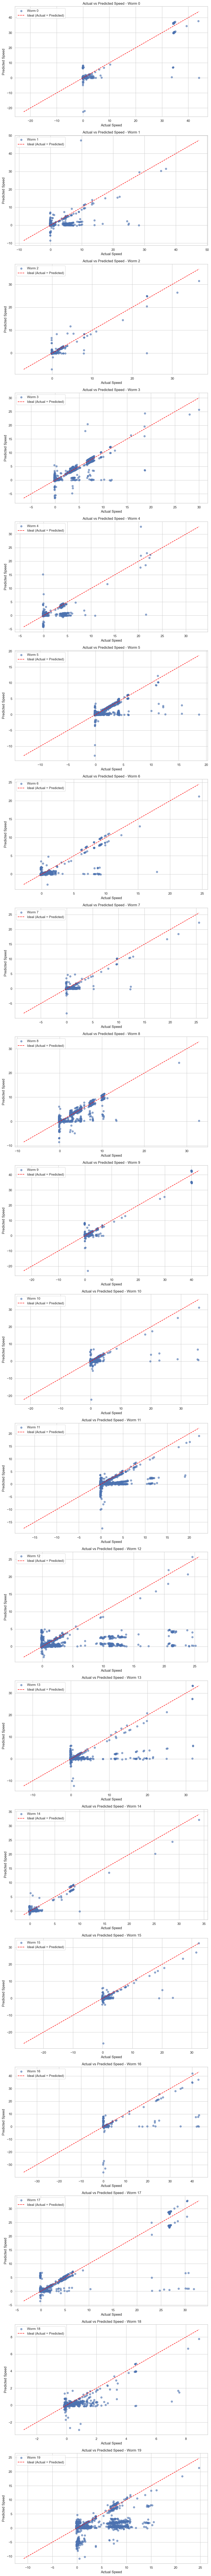

In [ ]:
sns.set(style="whitegrid")

# Unique worms
unique_worms = df['worm_id'].unique()

# Create subplots for each worm
fig, axes = plt.subplots(len(unique_worms), 1, figsize=(10, 6 * len(unique_worms)))

# If there's only one worm, adjust the axes
if len(unique_worms) == 1:
    axes = [axes]

# Loop through each worm and plot
for i, worm in enumerate(unique_worms):
    worm_data = df[df['worm_id'] == worm]  # Filter for this worm
    ax = axes[i]
    
    # Scatter plot for actual vs predicted speed
    ax.scatter(worm_data['actual_speed'], worm_data['predicted_speed'], alpha=0.6, label=f'Worm {worm}')
    
    # Add ideal line (Actual = Predicted)
    min_speed = min(worm_data['actual_speed'].min(), worm_data['predicted_speed'].min())
    max_speed = max(worm_data['actual_speed'].max(), worm_data['predicted_speed'].max())
    ax.plot([min_speed, max_speed], [min_speed, max_speed], linestyle='--', color='red', label='Ideal (Actual = Predicted)')
    
    # Titles and labels
    ax.set_title(f'Actual vs Predicted Speed - Worm {worm}')
    ax.set_xlabel('Actual Speed')
    ax.set_ylabel('Predicted Speed')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

CNN 

In [104]:
import tensorflow as tf


# Expand dimensions for CNN
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)

print(X_train_cnn.shape)
print(X_test_cnn.shape)

input_shape1 = X_train_cnn.shape[1]
input_shape2 = X_train_cnn.shape[2]

batch_size = 32
X_train_cnn = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train))
X_train_cnn = X_train_cnn.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


X_test_cnn = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test))
X_test_cnn = X_test_cnn.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

mean_speed = y_test.mean()
print(mean_speed)


(1154415, 15, 1)
(1154426, 15, 1)
-0.002135828018637299


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


model = Sequential([
    #initial filter 32
    Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(input_shape1, input_shape2)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    #initial filter 64
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')  # For regression; use 'sigmoid' for binary classification
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.0001)
# Train the model
'''
history = model.fit(
    X_train_cnn, y_train,
    epochs=3,
    batch_size=32,
    validation_data=(X_test_cnn,  y_test),
    callbacks=[early_stopping],
    verbose=1
)'''

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Monitor validation loss
    factor=0.5,             # Reduce LR by half
    patience=5,             # Wait for 5 epochs without improvement
    min_lr=1e-6,            # Don't reduce LR below this value
    verbose=1               # Print messages when LR is reduced
)

history = model.fit(
    X_train_cnn,
    epochs=50,
    validation_data=X_test_cnn,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate the model
#loss, mae = model.evaluate(X_test_cnn, y_test, verbose=0)
loss, mae = model.evaluate(X_test_cnn, verbose=0)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
y_pred = model.predict(X_test_cnn)

# Plot training history

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/50


c:\Users\srush\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36076/36076 ━━━━━━━━━━━━━━━━━━━━ 164s 5ms/step - loss: 0.5968 - mae: 0.1532 - val_loss: 0.4637 - val_mae: 0.1488 - learning_rate: 0.0010
Epoch 2/50
36076/36076 ━━━━━━━━━━━━━━━━━━━━ 178s 5ms/step - loss: 0.3974 - mae: 0.1166 - val_loss: 0.4394 - val_mae: 0.1600 - learning_rate: 0.0010
Epoch 3/50
36076/36076 ━━━━━━━━━━━━━━━━━━━━ 160s 4ms/step - loss: 0.4074 - mae: 0.1163 - val_loss: 0.4079 - val_mae: 0.1445 - learning_rate: 0.0010
Epoch 4/50
36072/36076 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3900 - mae: 0.1149

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout



time_steps = 20  # Number of past timesteps used for prediction
X_train_LSTM = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
X_test_LSTM = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])


# Define LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(time_steps, X_train_LSTM.shape[2])),
    Dropout(0.3),  # Regularization to avoid overfitting
    
    LSTM(32, activation='tanh', return_sequences=False),  # Final LSTM layer
    Dropout(0.2),
    
    Dense(16, activation='relu'),  # Fully connected layer
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

model.summary()
